In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# Removed the problematic import
# from imblearn.over_sampling import SMOTE
import streamlit as st
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to C:\Users\Pragnya
[nltk_data]     Reddy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Pragnya
[nltk_data]     Reddy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Pragnya
[nltk_data]     Reddy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
# Step 1: Web scrape Wikipedia page for Malaysia
url = "https://en.wikipedia.org/wiki/Malaysia"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

In [4]:
print(f"Response Status: {response.status_code}")
print(f"Page Title: {soup.title.string}")

Response Status: 200
Page Title: Malaysia - Wikipedia


In [5]:
# Step 2: Scrape only text
paragraphs = []
content_div = soup.find("div", {"id": "mw-content-text"})
if content_div:
    for p in content_div.find_all("p"):
        if p.text.strip():
            paragraphs.append(p.text)

In [6]:
# Combine all paragraphs into one text
raw_text = ' '.join(paragraphs)

In [7]:
print(f"Total characters extracted: {len(raw_text)}")
print(f"Preview of the text: {raw_text[:500]}...")

Total characters extracted: 61389
Preview of the text: – in Asia (dark gray & white)– in ASEAN (dark gray) Malaysia[d] is a country in Southeast Asia. A federal constitutional monarchy, it consists of 13 states and three federal territories, separated by the South China Sea into two regions: Peninsular Malaysia and Borneo's East Malaysia. Peninsular Malaysia shares a land and maritime border with Thailand and maritime borders with Singapore, Vietnam, and Indonesia. East Malaysia shares land borders with Brunei and Indonesia, as well as a maritime bo...


In [8]:
# Step 3: Clean Text and preprocessing
def clean_text(text):
    # Remove citations [1], [2], etc.
    text = re.sub(r'\[\d+\]', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^\w\s.]', '', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

cleaned_text = clean_text(raw_text)

In [9]:
print(f"Total characters after cleaning: {len(cleaned_text)}")
print(f"Preview of the cleaned text: {cleaned_text[:500]}...")

Total characters after cleaning: 58091
Preview of the cleaned text: in Asia dark gray white in ASEAN dark gray Malaysiad is a country in Southeast Asia. A federal constitutional monarchy it consists of 13 states and three federal territories separated by the South China Sea into two regions Peninsular Malaysia and Borneos East Malaysia. Peninsular Malaysia shares a land and maritime border with Thailand and maritime borders with Singapore Vietnam and Indonesia. East Malaysia shares land borders with Brunei and Indonesia as well as a maritime border with the Phil...


In [10]:
# Step 4: Use Sentence Tokenizer and sentence tokenize
sentences = sent_tokenize(cleaned_text)
print(f"Total number of sentences: {len(sentences)}")
print(f"First 5 sentences:")
for i, sent in enumerate(sentences[:5]):
    print(f"{i+1}. {sent}")


Total number of sentences: 470
First 5 sentences:
1. in Asia dark gray white in ASEAN dark gray Malaysiad is a country in Southeast Asia.
2. A federal constitutional monarchy it consists of 13 states and three federal territories separated by the South China Sea into two regions Peninsular Malaysia and Borneos East Malaysia.
3. Peninsular Malaysia shares a land and maritime border with Thailand and maritime borders with Singapore Vietnam and Indonesia.
4. East Malaysia shares land borders with Brunei and Indonesia as well as a maritime border with the Philippines and Vietnam.
5. Kuala Lumpur is the national capital the countrys largest city and the seat of the legislative branch of the federal government.


In [11]:
# Step 5: Use TextBlob and analyze_sentiment() function to calculate sentiment of sentences
def get_sentiment(sentence):
    analysis = TextBlob(sentence)
    polarity = analysis.sentiment.polarity
    
    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'

In [12]:
# Calculate sentiment for each sentence
sentiment_results = []
for sentence in sentences:
    blob = TextBlob(sentence)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    sentiment = get_sentiment(sentence)
    
    sentiment_results.append({
        'sentence': sentence,
        'polarity': polarity,
        'subjectivity': subjectivity,
        'sentiment': sentiment
    })

In [13]:
# Step 6: Create a dataframe of sentences and sentiment
sentiment_df = pd.DataFrame(sentiment_results)

In [14]:
print(f"Dataframe shape: {sentiment_df.shape}")

Dataframe shape: (470, 4)


In [15]:
print("\nFirst 5 rows of the sentiment dataframe:")


First 5 rows of the sentiment dataframe:


In [16]:
print(sentiment_df.head())

                                            sentence  polarity  subjectivity  \
0  in Asia dark gray white in ASEAN dark gray Mal...      -0.1      0.266667   
1  A federal constitutional monarchy it consists ...       0.0      0.000000   
2  Peninsular Malaysia shares a land and maritime...       0.0      0.000000   
3  East Malaysia shares land borders with Brunei ...       0.0      0.000000   
4  Kuala Lumpur is the national capital the count...       0.0      0.000000   

  sentiment  
0   neutral  
1   neutral  
2   neutral  
3   neutral  
4   neutral  


In [17]:
print("\nSentiment distribution:")
print(sentiment_df['sentiment'].value_counts())


Sentiment distribution:
sentiment
neutral     331
positive    101
negative     38
Name: count, dtype: int64


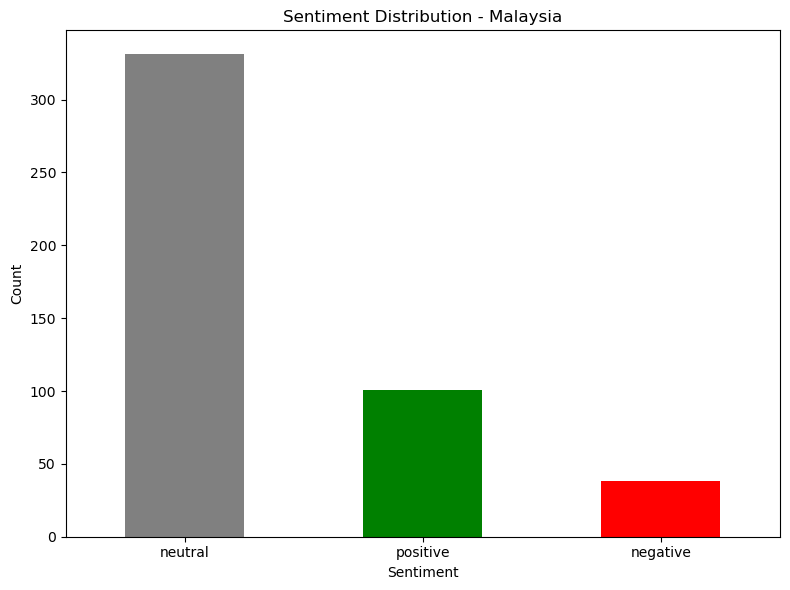

In [18]:
# Visualize sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_df['sentiment'].value_counts().plot(kind='bar', color=['gray', 'green', 'red'])
plt.title('Sentiment Distribution - Malaysia')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [19]:
# Step 7: Word tokenize the text data
words = word_tokenize(cleaned_text.lower())
print(f"Total words found: {len(words)}")
print(f"First 20 words: {words[:20]}")

Total words found: 9619
First 20 words: ['in', 'asia', 'dark', 'gray', 'white', 'in', 'asean', 'dark', 'gray', 'malaysiad', 'is', 'a', 'country', 'in', 'southeast', 'asia', '.', 'a', 'federal', 'constitutional']


In [20]:
# Step 8: Remove stopwords
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word.isalpha() and word not in stop_words]

In [21]:
print(f"Words after removing stopwords: {len(filtered_words)}")
print(f"First 20 filtered words: {filtered_words[:20]}")

Words after removing stopwords: 5188
First 20 filtered words: ['asia', 'dark', 'gray', 'white', 'asean', 'dark', 'gray', 'malaysiad', 'country', 'southeast', 'asia', 'federal', 'constitutional', 'monarchy', 'consists', 'states', 'three', 'federal', 'territories', 'separated']


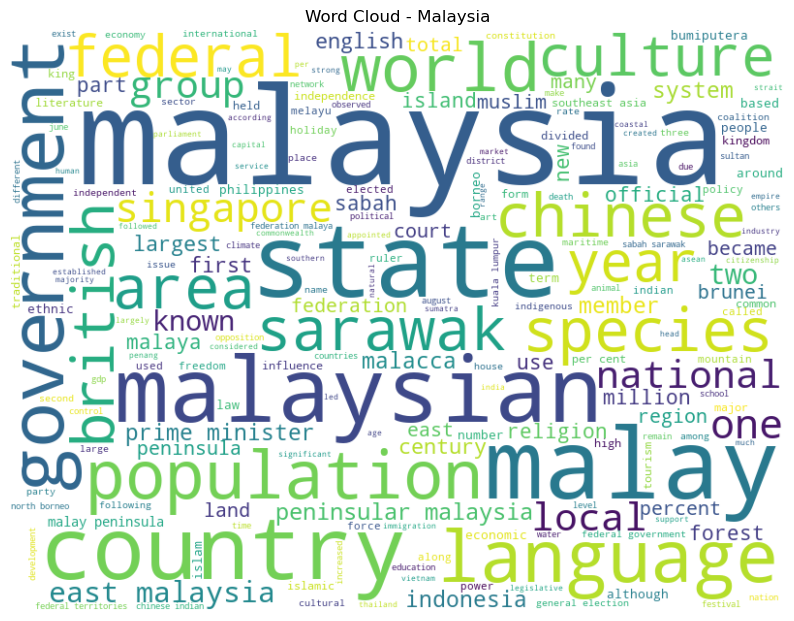

In [22]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=600, background_color='white').generate(' '.join(filtered_words))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Malaysia')
plt.show()

In [23]:
# Most common words
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(20)
words_df = pd.DataFrame(common_words, columns=['word', 'count'])

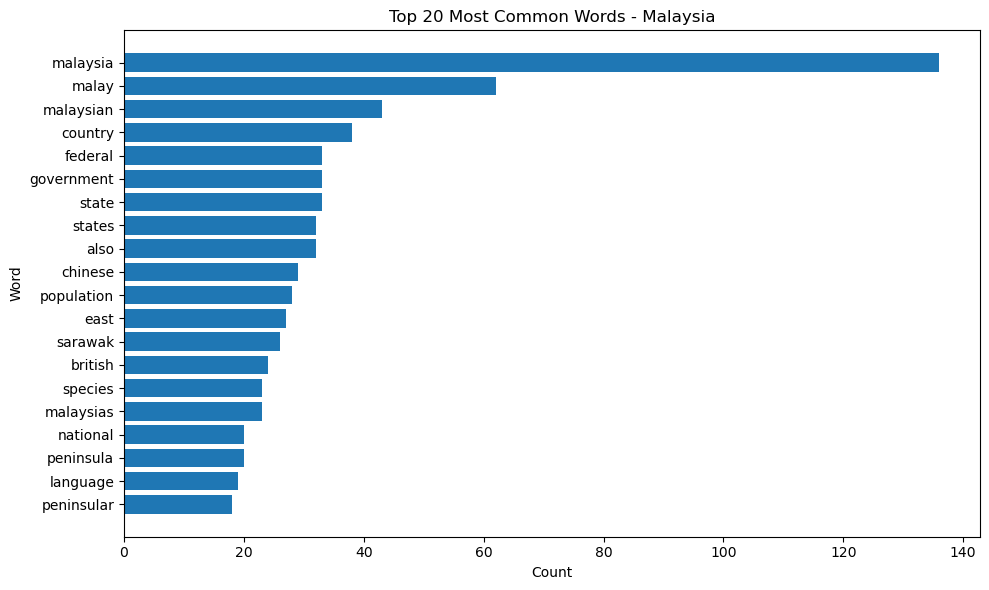

In [24]:
plt.figure(figsize=(10, 6))
plt.barh(words_df['word'], words_df['count'])
plt.title('Top 20 Most Common Words - Malaysia')
plt.xlabel('Count')
plt.ylabel('Word')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [25]:
# Step 11: Apply TFIDF Vectorizer on sentences and sentiment dataframe
# Step 12: Use only positive and negative sentiments only & ignore neutral
filtered_sentiment_df = sentiment_df[sentiment_df['sentiment'] != 'neutral']
print(f"Dataframe shape after removing neutral sentiments: {filtered_sentiment_df.shape}")
print(filtered_sentiment_df['sentiment'].value_counts())

# Prepare data for ML models
X = filtered_sentiment_df['sentence']
y = filtered_sentiment_df['sentiment']

# Convert text to TFIDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=2)
X_tfidf = tfidf_vectorizer.fit_transform(X)

print(f"TFIDF matrix shape: {X_tfidf.shape}")

Dataframe shape after removing neutral sentiments: (139, 4)
sentiment
positive    101
negative     38
Name: count, dtype: int64
TFIDF matrix shape: (139, 318)


In [26]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 111
Testing samples: 28


Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         8
    positive       0.71      1.00      0.83        20

    accuracy                           0.71        28
   macro avg       0.36      0.50      0.42        28
weighted avg       0.51      0.71      0.60        28



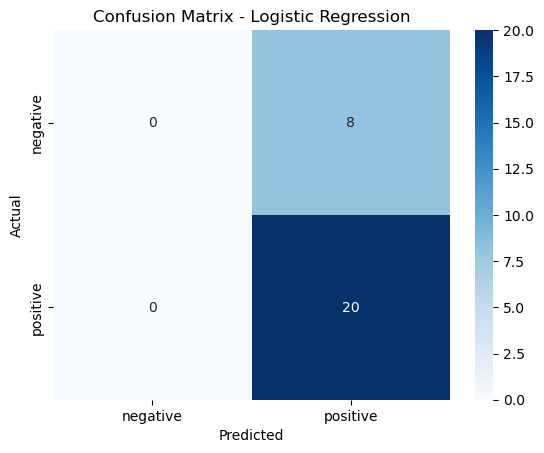

In [27]:
import seaborn as sns

# Logistic Regression
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train, y_train)

# Predictions
lr_preds = lr_model.predict(X_test)

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_preds))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, lr_preds)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=lr_model.classes_, yticklabels=lr_model.classes_)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Naive Bayes Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         8
    positive       0.71      1.00      0.83        20

    accuracy                           0.71        28
   macro avg       0.36      0.50      0.42        28
weighted avg       0.51      0.71      0.60        28



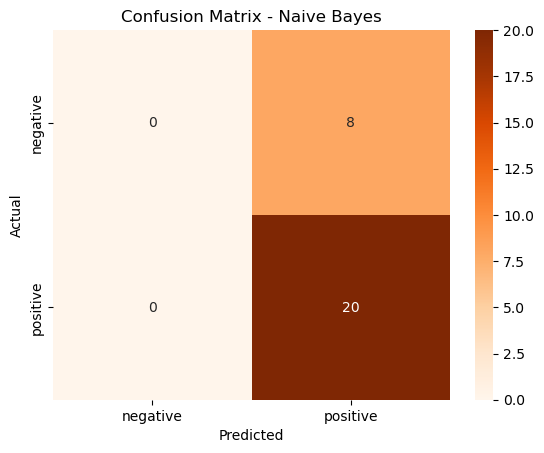

In [28]:
# Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predictions
nb_preds = nb_model.predict(X_test)

# Evaluation
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_preds))

# Confusion Matrix
cm_nb = confusion_matrix(y_test, nb_preds)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Oranges', xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [29]:
print("Accuracy Score:", accuracy_score(y_test, nb_preds))

Accuracy Score: 0.7142857142857143
